In [1]:
from typing import Callable, List, Tuple

import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch import nn
from torch.distributions.distribution import Distribution
from pytorch_lightning.loggers import TensorBoardLogger
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
from NFconstants import N_nod, Beta, a
from NFandist import get_O
from NFandist import get_diag
from NFandist import get_C
from Data import normal_dist

def set_random_seed(seed):
    torch.manual_seed(seed)
O=(torch.tensor(get_O(N_nod)).float()).to(device)
Ot=(torch.t(O)).to(device)
print(Ot.requires_grad)



False


In [11]:
class ThetaNetwork(nn.Module):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        num_hidden: int,
        hidden_dim: int,
        num_params: int,
        p_drop: float,
    ):
        super().__init__()
        self.input = nn.Linear(in_dim, hidden_dim)
        self.hidden = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.Dropout(p=p_drop),
                nn.LayerNorm(hidden_dim)
            ) for _ in range(num_hidden)]
        )

        self.num_params = num_params
        self.out_dim = out_dim
        self.dims = nn.Linear(hidden_dim, out_dim * num_params)
        
    def configure_theta(num_hidden,hidden_dim,p_drop,in_dim=N_nod//2,out_dim=N_nod//2):
        theta=ThetaNetwork(
                in_dim = in_dim,
                out_dim = out_dim,
                num_hidden = num_hidden,  #2 to 6
                hidden_dim = hidden_dim , #100-1024
                num_params = 2,
                p_drop=p_drop,
        )
        return theta    

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.leaky_relu(self.input(x),negative_slope=0.01)
        for h in self.hidden:
            x = F.leaky_relu(h(x),negative_slope=0.01)

        batch_params = self.dims(x).reshape(x.size(0), self.out_dim, -1) 
        params = batch_params.chunk(self.num_params, dim=-1) 
        return [p.squeeze(-1) for p in params]

In [12]:
class AffineCouplingLayer(nn.Module):
    def __init__(
        self,
        theta: nn.Module,
        split,
        swap: int
    ):
        super().__init__()
        self.theta = theta
        self.split = split
        self.swap = swap

    def g(self, z: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        """g : z -> x. The inverse of f."""
        mask1=self.split[self.swap]
        mask2=self.split[(self.swap+1)%2]
        z1, z2 = z[:,mask1], z[:,mask2]
        z1 = torch.cat((z1,params),dim=-1)
        t, s = self.theta(z1)
        x2 = z2 * torch.exp(s) + t
        log_det = s.sum(-1) 
        z[:,mask2]=x2
        return z, log_det

    def f(self, x: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        mask1=self.split[self.swap]
        mask2=self.split[(self.swap+1)%2]
        x1, x2 = x[:,mask1], x[:,mask2]
        x1 = torch.cat((x1,params),dim=-1)
        t, s = self.theta(x1)
        z1, z2 = x1, torch.exp(-s)*(x2-t) 
        log_det = s.sum(-1) 
        x[:,mask2] = z2
        return x, log_det    

In [13]:
def get_split_masks(dim=N_nod):
    mask1=list(range(0,dim,2))
    mask2=list(range(1,dim,2))
    split_masks=[mask1,mask2]
    return split_masks
    
def get_pair_split_masks(dim=N_nod):
    mask1=list(range(0,dim,4))
    mask2=list(range(2,dim,4))
    mask1=(mask1+list(map(lambda x:x+1,mask1)))
    mask2=(mask2+list(map(lambda x:x+1,mask2)))
    mask1.sort()
    mask2.sort()
    split_masks=[mask1,mask2]
    return split_masks    

In [14]:
class NormalizingFlow(nn.Module):
    
    def __init__(self, latent: Distribution, flows: List[nn.Module], ort=False, Ot=[]):
        super().__init__()
        self.latent = latent
        self.flows = flows
        self.ort = ort
        self.Ot = Ot
        
    def configure_flows(n_flows,num_hidden,hidden_dim,p_drop,dim=N_nod,param_dim=0):  # n_flows=8,...,12
        flows = []
        split_masks_d = get_pair_split_masks(dim)
        #split_masks_d = get_split_masks(dim)
    
        for k in range(n_flows):
            theta = ThetaNetwork.configure_theta( num_hidden = num_hidden, hidden_dim = hidden_dim, p_drop=p_drop ,in_dim = dim//2+param_dim,out_dim = dim//2)
            flows.append(AffineCouplingLayer(theta,split=split_masks_d,swap=k%2))
   
        flows = nn.ModuleList(flows)
        return flows     

    def latent_sample(self, num_samples: int = 1) -> torch.Tensor:
        z=self.latent.sample((num_samples,))
        return z        

    def sample(self, num_samples: int = 1) -> torch.Tensor:
        """Sample a new observation x by sampling z from
        the latent distribution and pass through g."""
        z=(self.latent_sample(num_samples))
        with torch.no_grad():
            x, _ = self.g(z)
        return x 
    

    def g(self, z: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        
        x, sum_log_abs_det = z, torch.zeros(z.size(0)).to(z.device)
        for flow in reversed(self.flows):
            x, log_abs_det = flow.g(x,params)
            sum_log_abs_det += log_abs_det
        
        if self.ort:
            x = torch.matmul(x,self.Ot.to(x.device))
            
        return x, sum_log_abs_det
    
        
    def __len__(self) -> int:
        return len(self.flows)
    
    def f(self, x: torch.Tensor,params=torch.tensor([])) -> Tuple[torch.Tensor, torch.Tensor]:
        
        with torch.no_grad():
            if self.ort:
                x=torch.matmul(x,O.to(x.device))
        
            z, sum_log_abs_det = x, torch.zeros(x.size(0)).to(x.device)
        
            for flow in self.flows:
                z, log_abs_det = flow.f(z,params)
                sum_log_abs_det += log_abs_det
        
        return z, sum_log_abs_det
    
 
"""
    def g_steps(self, z: torch.Tensor) -> List[torch.Tensor]:
        Maps latent variable z to observation x
        and stores intermediate results.
        
        xs = [z]
        for flow in reversed(self.flows):
            xs.append(flow.g(xs[-1]))
        return xs

    
    def latent_log_prob(self, z: torch.Tensor) -> torch.Tensor:
        llp=self.latent.log_prob(z)
        sum_llp= torch.sum(llp,axis=-1)
        return sum_llp
 
    
"""
    

'\n    def g_steps(self, z: torch.Tensor) -> List[torch.Tensor]:\n        Maps latent variable z to observation x\n        and stores intermediate results.\n        \n        xs = [z]\n        for flow in reversed(self.flows):\n            xs.append(flow.g(xs[-1]))\n        return xs\n\n    \n    def latent_log_prob(self, z: torch.Tensor) -> torch.Tensor:\n        llp=self.latent.log_prob(z)\n        sum_llp= torch.sum(llp,axis=-1)\n        return sum_llp\n \n    \n'

In [15]:
from NFoscillator import Oscillator
from NFrel_oscillator import Rel_Oscillator
from NFur_oscillator import Ur_Oscillator
from NFx4 import X4
from NFMorse import Morse
from NFrel_Morse import Rel_Morse
from NFrel_Columb import Rel_Columb
from NFnonrel_Columb import NonRel_Columb
from NFbadur_oscillator import BadUr_Oscillator
from NFtwowells import Two_wells
from NFcircle import Circle
from NFrel_twowells import Rel_two_wells 

osc=Oscillator(N_nod,Beta)
KL_osc=osc.get_KL()

rel1=Rel_Oscillator(N_nod,Beta,sigma=1)
KL_rel1=rel1.get_KL()

ur=Ur_Oscillator(N_nod,Beta)
KL_ur=ur.get_KL()

ur8=Ur_Oscillator(8,Beta)
KL_ur8=ur8.get_KL()

rel_columb=Rel_Columb(N_nod,Beta,alpha=1,R=1)
KL_rel_columb=rel_columb.get_KL()

tw = Two_wells(N_nod,Beta,g=1,x0=1.41)
KL_tw = tw.get_KL()


morse = Morse(N_nod,Beta,alpha=0.125)
KL_morse = morse.get_KL()

circ = Circle(N_nod,Beta,g=1,x0=4)
KL_circ = circ.get_KL()

rel_morse = Rel_Morse(N_nod,Beta,m=1,alpha=0.125)
KL_rel_morse = rel_morse.get_KL()

rel_tw = Rel_two_wells(N_nod,Beta,m=1,g=1,x0=1.41)
KL_rel_tw = rel_tw.get_KL()

KL_rel001=Rel_Oscillator(N_nod,Beta,sigma=0.01).get_KL()
KL_rel01=Rel_Oscillator(N_nod,Beta,sigma=0.1).get_KL()
KL_rel10=Rel_Oscillator(N_nod,Beta,sigma=10).get_KL()
KL_rel29=Rel_Oscillator(N_nod,Beta,sigma = 2 ** 9).get_KL()
KL_X4=X4(N_nod,Beta,g=0.05).get_KL()
KL_rel_morse=Rel_Morse(N_nod,Beta,alpha=1,m=1000).get_KL()
KL_nonrel_columb=NonRel_Columb(N_nod,Beta,alpha=1,R=1).get_KL()


In [16]:
class Pipeline(pl.LightningModule):
    def __init__(
        self,
        model,
        criterion,
        optimizer_class=torch.optim.Adam,
        optimizer_kwargs={"lr": 0.001,"weight_decay": 0}
    ) -> None:
        super().__init__()
        self.model = model
        self.loss = criterion
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs


    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        z = batch
        x, log_abs_det = self.model.g(z)
        loss = self.loss(x,log_abs_det)
        self.log('train_loss', loss, prog_bar=True)
        return loss


    def on_train_epoch_end(self):
        #print("---------------------------end epoch---------------------------------")
        pass
    
    def on_validation_end(self) -> None:
        if not self.automatic_optimization:
            # Save a checkpoint of the model
            ckpt_path = os.path.join(self.trainer.log_dir, 'checkpoints', 'ckpt.pt')
            self.trainer.save_checkpoint(ckpt_path, weights_only=True)
        return super().on_validation_end()
    
    

In [17]:
from Data import train_loader

set_random_seed(42)
flows = NormalizingFlow.configure_flows(n_flows=12,num_hidden=4,hidden_dim=128,p_drop=0.0,dim=N_nod,param_dim=0)
nf=NormalizingFlow(normal_dist,flows,True,Ot)
pipeline=Pipeline(model=nf, criterion=KL_osc, optimizer_class=torch.optim.Adam, optimizer_kwargs={"lr": 0.0001,"weight_decay":0.0})

trainer = pl.Trainer(
    max_epochs=50,
    logger=TensorBoardLogger(save_dir=f"logs/nf"),
    num_sanity_val_steps=0,
    log_every_n_steps=1,
    accumulate_grad_batches=1
)

trainer.fit(model=pipeline, train_dataloaders=train_loader)
torch.save(nf.state_dict(), "model_weights1.pth")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type            | Params
------------------------------------------
0 | model | NormalizingFlow | 954 K 
1 | loss  | KL_with_S       | 0     
------------------------------------------
954 K     Trainable params
0         Non-trainable params
954 K     Total params
3.818     Total estimated model params size (MB)
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |                                                                                      | 0/? [00:00<…

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [26]:
from Data import train_loader

set_random_seed(42)
nf=NormalizingFlow(latent=normal_dist,flows=configure_flows(12),conv_flows=configure_conv_flows(0,kernel_size=16),ort=True)
nf.load_state_dict(torch.load('model_weights1.pth'))
pipeline=Pipeline(model=nf,criterion=KL_morse, optimizer_class=torch.optim.Adam,optimizer_kwargs={"lr": 0.0001,"weight_decay":0.0})

trainer = pl.Trainer(
    max_epochs=20,
    logger=TensorBoardLogger(save_dir=f"logs/nf"),
    num_sanity_val_steps=0,
    log_every_n_steps=1,
    enable_checkpointing=False,
    accumulate_grad_batches=1
)

trainer.fit(model=pipeline, train_dataloaders=train_loader)
torch.save(nf.state_dict(), "model_weights1.pth")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type            | Params
------------------------------------------
0 | model | NormalizingFlow | 3.4 M 
1 | loss  | KL_with_S       | 0     
------------------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params
13.477    Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.


In [11]:
from Data import normal_dist
import numpy as np
from NFconstants import N_traj
flows = NormalizingFlow.configure_flows(n_flows=12,num_hidden=4,hidden_dim=128,p_drop=0.0,dim=N_nod,param_dim=0)
NF_trained=NormalizingFlow(normal_dist,flows,True,Ot)
NF_trained.load_state_dict(torch.load('model_weights1.pth'))
NF_trained.eval()
print(NF_trained.ort)
trajs=NF_trained.sample(N_traj)


True


In [12]:
from tqdm import tqdm
def G(X,n_p="all"):
    n_traj=X.shape[0]
    n_nod=X.shape[1]
    if n_p == "all":
        n_p = X.shape[1]
    G=np.zeros((n_p))
    Y=X.clone()
    Xt=torch.t(X)
    for s in tqdm(range(n_p)):
        G[s]=torch.trace(torch.matmul(Y,Xt))
        Y=torch.roll(Y,-1,1)
        #Y=torch.roll(Y,-1,1)
    return G/(n_traj*n_nod)
g_nf=G(trajs)


100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 242.96it/s]


In [1]:
from NFandist import calc_G
from NFconstants import N_nod, N_traj, NG_points,Beta
g_osc=calc_G(N_nod,Beta,N_nod)


In [36]:
g_ur = [0.476546, 0.148654, 0.060357, 0.0232596, -0.00447499, -0.00224423, -0.00447499, 0.0232596, 0.060357, 0.148654]

In [50]:

g_ur = [0.555858, 0.497988, 0.446597, 0.401115, 0.360415, 0.324316, 0.29138, 0.261791, 0.235658, 0.211969, 0.190536, 0.171994, 0.155133, 0.140335, 0.126598, 0.114471, 0.103514, 0.0941716, 0.0852865, 0.0767528, 0.0691313, 0.0619047, 0.0550745, 0.0490998, 0.0443236, 0.0396256, 0.0358628, 0.0324961, 0.0302019, 0.0276177, 0.0251373, 0.0226234, 0.0203086, 0.0179717, 0.0164385, 0.0152739, 0.0143051, 0.0136778, 0.0127566, 0.0118486, 0.0111658, 0.0111462, 0.011026, 0.0110081, 0.0109681, 0.0106729, 0.0101027, 0.010377, 0.010866, 0.0114044, 0.0119873, 0.0114044, 0.010866, 0.010377, 0.0101027, 0.0106729, 0.0109681, 0.0110081, 0.011026, 0.0111462, 0.0111658, 0.0118486, 0.0127566, 0.0136778, 0.0143051, 0.0152739, 0.0164385, 0.0179717, 0.0203086, 0.0226234, 0.0251373, 0.0276177, 0.0302019, 0.0324961, 0.0358628, 0.0396256, 0.0443236, 0.0490998, 0.0550745, 0.0619047, 0.0691313, 0.0767528, 0.0852865, 0.0941716, 0.103514, 0.114471, 0.126598, 0.140335, 0.155133, 0.171994, 0.190536, 0.211969, 0.235658, 0.261791, 0.29138, 0.324316, 0.360415, 0.401115, 0.446597, 0.497988]


In [ ]:
g_ur = np.genfromtxt("g_ur N=256 Beta=16")

In [29]:
g_rel = [0.389004, 0.174591, 0.0750764, 0.0320855, 0.0235634, 0.0204869, 0.0235634, 0.0320855, 0.0750764, 0.174591]

In [53]:
g_rel = [0.392501, 0.361773, 0.333519, 0.307446, 0.283335, 0.261201, 0.240658, 0.221871, 0.204776, 0.188963, 0.174495, 0.161116, 0.148541, 0.136946, 0.126175, 0.116168, 0.106934, 0.0985733, 0.090693, 0.0836987, 0.0773237, 0.0713712, 0.0662134, 0.0611666, 0.0567049, 0.0525145, 0.0489322, 0.045775, 0.043085, 0.0407685, 0.0383386, 0.0365845, 0.0353032, 0.0339074, 0.0324167, 0.0308972, 0.0295226, 0.0285374, 0.0276133, 0.026899, 0.0265193, 0.0267518, 0.027023, 0.0272673, 0.0275789, 0.0277296, 0.0281657, 0.0286108, 0.0289897, 0.0292072, 0.0292838, 0.0292072, 0.0289897, 0.0286108, 0.0281657, 0.0277296, 0.0275789, 0.0272673, 0.027023, 0.0267518, 0.0265193, 0.026899, 0.0276133, 0.0285374, 0.0295226, 0.0308972, 0.0324167, 0.0339074, 0.0353032, 0.0365845, 0.0383386, 0.0407685, 0.043085, 0.045775, 0.0489322, 0.0525145, 0.0567049, 0.0611666, 0.0662134, 0.0713712, 0.0773237, 0.0836987, 0.090693, 0.0985733, 0.106934, 0.116168, 0.126175, 0.136946, 0.148541, 0.161116, 0.174495, 0.188963, 0.204776, 0.221871, 0.240658, 0.261201, 0.283335, 0.307446, 0.333519, 0.361773]


In [91]:

import numpy as np
corr = [0.0049279, 0.00445719, 0.0040318, 0.00364688, 0.00329375, 0.00297512, 0.00268571, 0.00242197, 0.00217813, 0.00195686, 0.00176504, 0.001597, 0.0014406, 0.00130362, 0.00117932, 0.00107197, 0.000971531, 0.000873839, 0.000783014, 0.000698531, 0.000622945, 0.000554938, 0.000497423, 0.000446639, 0.000400234, 0.000360026, 0.000325092, 0.00028936, 0.000252744, 0.000222755, 0.00019756, 0.000178826, 0.000169581, 0.000165766, 0.000161208, 0.000158499, 0.000157808, 0.000156267, 0.000155463, 0.000151827, 0.000137475, 0.000124214, 0.000113485, 0.000104859, 9.63436e-05, 8.8317e-05, 8.17296e-05, 7.9884e-05, 7.83747e-05, 8.01024e-05, 8.44507e-05, 8.01024e-05, 7.83747e-05, 7.9884e-05, 8.17296e-05, 8.8317e-05, 9.63436e-05, 0.000104859, 0.000113485, 0.000124214, 0.000137475, 0.000151827, 0.000155463, 0.000156267, 0.000157808, 0.000158499, 0.000161208, 0.000165766, 0.000169581, 0.000178826, 0.00019756, 0.000222755, 0.000252744, 0.00028936, 0.000325092, 0.000360026, 0.000400234, 0.000446639, 0.000497423, 0.000554938, 0.000622945, 0.000698531, 0.000783014, 0.000873839, 0.000971531, 0.00107197, 0.00117932, 0.00130362, 0.0014406, 0.001597, 0.00176504, 0.00195686, 0.00217813, 0.00242197, 0.00268571, 0.00297512, 0.00329375, 0.00364688, 0.0040318, 0.00445719, 0.0049279]
g_rel_001=(100*np.array(corr))[:-1]



In [34]:
import numpy as np
corr = [0.0482165, 0.0437875, 0.0397512, 0.0361339, 0.0328051, 0.0297607, 0.0270138, 0.0244825, 0.0222039, 0.0201489, 0.0183026, 0.0166458, 0.0151002, 0.0137192, 0.012421, 0.0112716, 0.0102497, 0.00931179, 0.0084281, 0.00763501, 0.00697282, 0.00637519, 0.00579578, 0.00524782, 0.00469027, 0.00419239, 0.00376016, 0.00335117, 0.00299975, 0.00265075, 0.00236496, 0.00215769, 0.00196452, 0.00178665, 0.00162977, 0.00148276, 0.00135563, 0.00127519, 0.00120796, 0.00115448, 0.0011155, 0.00109623, 0.00112555, 0.00113097, 0.00108849, 0.00108302, 0.00112726, 0.00115736, 0.00118966, 0.00124266, 0.00121678, 0.00124266, 0.00118966, 0.00115736, 0.00112726, 0.00108302, 0.00108849, 0.00113097, 0.00112555, 0.00109623, 0.0011155, 0.00115448, 0.00120796, 0.00127519, 0.00135563, 0.00148276, 0.00162977, 0.00178665, 0.00196452, 0.00215769, 0.00236496, 0.00265075, 0.00299975, 0.00335117, 0.00376016, 0.00419239, 0.00469027, 0.00524782, 0.00579578, 0.00637519, 0.00697282, 0.00763501, 0.0084281, 0.00931179, 0.0102497, 0.0112716, 0.012421, 0.0137192, 0.0151002, 0.0166458, 0.0183026, 0.0201489, 0.0222039, 0.0244825, 0.0270138, 0.0297607, 0.0328051, 0.0361339, 0.0397512, 0.0437875, 0.0482165]
g_rel_01=(10*np.array(corr))[:-1]


0.48079470825195314


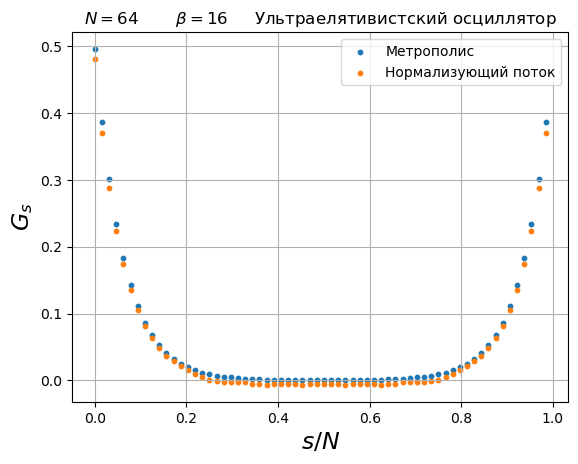

In [13]:
#import sys
#sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from NFconstants import N_nod, N_traj, NG_points,Beta




g=g_osc
print(g_nf[0])
fig=plt.figure()
MCMC_list=np.arange(len(g))/len(g)
NF_list=np.arange(len(g_nf))/len(g_nf)



plt.scatter(MCMC_list,g,s=10)
plt.scatter(NF_list,g_nf,s=10)
plt.legend(["Метрополис","Нормализующий поток"])
plt.title(r"$N=$"+str(N_nod)+"       "r"$\beta=$"+str(Beta)+"     Ультраелятивистский осциллятор")
plt.ylabel(r"$G_s$",fontsize=17)
plt.xlabel(r"$s/N$",fontsize=17)
#plt.yscale("log")
plt.grid(True)
plt.show()


In [41]:
K = (1 - 2 * (g_nf[0]-g_nf[1]) / a) / (2 * a)
print(K)
V2=g_nf[0]/2
print((3/2)*K+(1/2)*V2)

3.996154541015625
5.994833356201649


In [41]:


! du -sh logs






8.0K	logs


In [40]:
! rm -rf logs


rm: cannot remove 'logs/nf/lightning_logs/version_302': Directory not empty
rm: cannot remove 'logs/nf/lightning_logs/version_303': Directory not empty


Exception: Process exited with code 1

In [ ]:
def configure_flows(level_size,level_step=1):  # n_flows=8,...,12
    flows=[]
    n_levels=(N_latent-N_nod)//level_step
    
    if N_nod==N_latent:
        level_step=0
    
    dim=N_latent//2
    
    for i in range(n_levels):
        for k in range(level_size):
            flows.append(AffineCouplingLayer(configure_theta(dim,dim),split=pair_SplitFunc,swap=k%2))
        flows.append(nn.Linear(dim,dim-level_step//2))    
        dim-=level_step//2    
    
    if dim!=N_nod//2:
        print("smth wrong")
        
    for k in range(level_size):
        flows.append(AffineCouplingLayer(configure_theta(dim,dim),split=pair_SplitFunc,swap=k%2))
    flows = nn.ModuleList(flows)
    
    return flows 

In [11]:
print("start")
from Data import normal_dist

def configure_theta():
    theta=ThetaNetwork(
                in_dim = N_nod//2,
                out_dim = N_nod//2,
                num_hidden = 16,  #2 to 6
                hidden_dim = 2*N_nod , #100-1024
                num_params = 2,
                p_drop=0.4,
    )
    return theta

def configure_flows(n_flows):  # n_flows=8,...,12
    flows=[]
    
    flows.append(D(N_nod))
    
    for k in range(n_flows//4):
        flows.append(AffineCouplingLayer(configure_theta(),split=pair_SplitFunc,swap=k%2))
        flows.append(L1(N_nod))
    
    for k in range(3 * n_flows//4):
        flows.append(AffineCouplingLayer(configure_theta(),split=pair_SplitFunc,swap=k%2))
    
    flows.append(D(N_nod))    
    flows = nn.ModuleList(flows)
    return flows 

def configure_conv_flows(n_conv,kernel_size=3):
    conv_flows=[]
    for i in range(n_conv):
        conv_flows.append(AffineCouplingLayer(Conv_NN(N_nod//2,2,kernel_size),split=pair_SplitFunc,swap=i%2))
    conv_flows = nn.ModuleList(conv_flows)
    return conv_flows

print(normal_dist)

                  

start
Normal(loc: torch.Size([100]), scale: torch.Size([100]))


In [ ]:
from Data import normal_dist

def configure_theta():
    theta=ThetaNetwork(
                in_dim = N_nod//2,
                out_dim = N_nod//2,
                num_hidden = 16,  #2 to 6
                hidden_dim = 2 * N_nod , #100-1024
                num_params = 2,
                p_drop=0.0,
    )
    return theta

def configure_flows(n_flows):  # n_flows=8,...,12
    flows=[]
    
    flows.append(CubicCouplingLayer(configure_theta(),split=pair_SplitFunc,swap=0))
    flows.append(CubicCouplingLayer(configure_theta(),split=pair_SplitFunc,swap=1))
    
    flows.append(D(N_nod))

    for k in range(n_flows):
        flows.append(AffineCouplingLayer(configure_theta(),split=pair_SplitFunc,swap=k%2))
            
    
    flows = nn.ModuleList(flows)
    return flows 